#Wstęp

Ten plik zawiera rozwiązanie zadania do zadania 2. z algorytmów ewolucyjnych, odpowiedzialne za nie jest grupa numer 1 w składzie.

1. Jan Zoń 
2. Szymon Werk 
3. Mateusz Kruk 
4. Maciej Macuga 

##Treść zadania

Dany jest graf w postaci pliku tekstowego 

```
N 
x1 x2 …..
```

gdzie **N** oznacza liczbę wierzchołków, a kolejne liczby oznaczają krawędzie. 

Przykładowo 

```
4 
1 3 1 4 2 3 2 4
```

Opisuje graf o 4 wierzchołkach i 4 krawędziach łączących wierzchołki 1 z 3. 1 z 4 2 z 3 oraz 2 z 4 

---

Należy znaleźć współrzędne środków wierzchołków, tak aby narysowany graf ma jak najmniej przecinających się krawędzi. 

#Moduły

Do wykonania zadania zastosowaliśmy moduł pygad ([docs](https://pygad.readthedocs.io/en/latest/)), który wybraliśmy, gdyż dobrze się sprawdziła w nim praca w poprzednim zadaniu oraz posiada dobrze opisaną dokumentacje. 

In [ ]:
%pip install pygad
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from itertools import combinations
import pygad
import numpy as np

#Wejście

Dla przypomnienia, na wejściu mamy N jako liczbę wierzchołków oraz krawędzie grafu.


---



Poniżej znajdują się dwa kawałki kodu. Pierwszy z nich jest sandboxem do dowolnego ustawiania grafu. Proszę samemu edytować kod w celu ustawienia grafu lub odkomentować jeden z przygotowanych przykładów.

Drugi z nich pozwala, zgodnie z treścią zadania, wczytać potrzebne informacje z pliku tekstowego. Proszę wpisać nazwę pliku oraz wrzucić go do sesji colaba lub ścieżki notatnika.

In [ ]:
# V = [] #wierzchołki
# V = [(11, 7),  (5, 9),  (17, 3),  (7, 8),  (19, 18),  (20, 5),  (15, 4),  (5, 14),  (17, 19),  (17, 15),  (6, 5),  (11, 6),  (8, 14),  (11, 4),  (14, 7),  (11, 17),  (4, 20),  (10, 14),  (18, 3),  (2, 3)]
# N = 20
# Przykład z zadania
# N = 4
# V.append((1,3))
# V.append((1,4))
# V.append((2,3))
# V.append((2,4))

# Graf spójny 
# N = 4
# V.append((1,4))
# V.append((1,2))
# V.append((1,3))
# V.append((2,3))
# V.append((2,4))
# V.append((3,4))

# Przykład 1
# N = 6 
# V.append((1,3))
# V.append((1,5))
# V.append((1,6))
# V.append((3,4))
# V.append((2,6))
# V.append((2,5))
# V.append((5,6))
# V.append((3,5))

#drzewo binarne
# N = 15
# V.append((1,2))
# V.append((1,3))
# V.append((2,4))
# V.append((2,5))
# V.append((3,6))
# V.append((3,7))
# V.append((4,8))
# V.append((4,9))
# V.append((5,10))
# V.append((5,11))
# V.append((6,12))
# V.append((6,13))
# V.append((7,14))
# V.append((7,15))

In [ ]:
# poprawione, działa
N = 0
V = []

with open('graf.txt', 'r') as f:
  lines = f.readlines()
  N = int(lines[0])
  input = lines[1].strip().split()
  for i in range(0, len(input), 2):
    V.append((int(input[i]), int(input[i+1])))

Proszę mieć na uwadze, że notatnik nie wykonuje sprawdzania lub czyszczenia danych, takich jak np.sprawdzania czy krawędzie się nie powtarzają (krawędź (1, 2) oraz (2, 1) ).

Nie jest to jednak w specyfikacji problemu, więc skupiliśmy się na nim, ale problem uwzględniamy tutaj.

#Funkcje pomocnicze

Tutaj znajdują się funkcje pomocnicze, które nie mają za zadanie wyliczanie optymalnej konfiguracji grafu, ale są potrzebne do konwersji oraz wizualizacji danych

In [ ]:
#zamień listę 2*N liczb rzeczywistych na listę krotek,
#odpowiadającej współrzędnym wierzchołka
def genG(bestFit, N):
  return [(bestFit[2*g], bestFit[2*g + 1]) for g in range(N)]

#zamień color wykresu na szary
color = '#9e9e9e'
#plt.rcParams['figure.facecolor'] = color

def drawGraph(G, V):
  for v in V:
    begin, end = v
    begin, end = begin - 1, end - 1
    X = [G[end][0], G[begin][0]]
    Y = [G[end][1], G[begin][1]]
    plt.plot(X, Y, color='#e8e9eb', zorder=1)
  plt.scatter([g[0] for g in G], [g[1] for g in G], zorder=2)
  for i, g in enumerate(G):
    plt.annotate(f'{i+1}', g, xytext=(g[0]+0.005, g[1]+0.005), color='blue', zorder=3)
  
  axs = plt.axes()
  axs.set_facecolor(color)
  
  plt.show()

#Funkcja główne

poniżej znajdują się funkcje służące do liczenia samego algorytmu

###Funkcje liczące przecięcia

In [ ]:
maxRange = 1

class Line:
  def __init__(self, g1, g2, a, b):
    self.pointA = g1
    self.pointB = g2
    self.A = a
    self.B = b
    self.dist = np.sqrt(np.power(g1[0] - g2[0], 2) + np.power(g1[1] - g2[1], 2))
  
  def inLine(self, x, y):
    X = np.array([self.pointA[0], self.pointB[0]])
    Y = np.array([self.pointA[1], self.pointB[1]])
    xMin, xMax = X.min(), X.max()
    yMin, yMax = Y.min(), Y.max()

    return xMin < x < xMax and yMin < y < yMax
  
  def pointOnEnd(self, x, y):
    epsilon = 1e-6
    dist1 = np.sqrt(np.power(self.pointA[0] - x,2) + np.power(self.pointA[1] - y,2))
    dist2 = np.sqrt(np.power(self.pointB[0] - x,2) + np.power(self.pointB[1] - y,2))
    return dist1 <= epsilon or dist2 <= epsilon

  def __str__(self):
    return f'g1: {self.pointA} g2: {self.pointB} a: {self.A} b: {self.B}'

def samePosition(g1, g2):
  x1, y1 = g1
  x2, y2 = g2
  return x1 == x2 and y1 == y2

def outOfRange(g):
  x, y = g
  return 0 > x or x > maxRange or 0 > y or y > maxRange

#oblicz równanie kierunkowe prostej przechodzącej przez dwa wierzchołki
def getLine(g1, g2):
  x1, y1 = g1
  x2, y2 = g2
  A = np.array([[x1, 1], [x2, 1]])
  b = np.array([y1, y2])
  x = np.linalg.solve(A, b)
  return Line(g1, g2, x[0], x[1])

def intersection(line1: Line, line2: Line):
  a1, b1 = line1.A, line1.B
  a2, b2 = line2.A, line2.B
  a1, a2 = -a1, -a2
  A = np.array([[a1, 1], [a2, 1]])
  b = np.array([b1, b2])
  x = np.linalg.solve(A, b)
  return x

###Dopasowanie

W tej części mamy funckje liczącą wartość dopasowania.

Z samego startu eliminujemy każdego osobnika, który ma współrzędnie wierzchołków poza **[0,1]** lub przynajmniej para wierzchołków ma te same współrzędne.

Metoda dla każdego wierzchołka liczy równanie kierunkowe prostej na której leży dany wierzchołek. Następnie liczone jest przecięcie dwóch prostych, by sprawdzić gdzie proste się przecinają. 

Z racji tego, że musimy sprawdzić wszystkie możliwe pary krawędzi, to ma ${|V|}\choose{2}$ możliwych przecięc, gdzie V to zbiór krawędzi.

Jeżeli obie proste mają ten sam współczynnik kierunkowy lub punkt przecięcia leży poza jedną z prostych lub punket przecięcia jest jeden z wierzchołków grafu, to wtedy zaliczamy, że dwie krawędzie nie mają przecięcia.

Samą wartość dopasowania zwracamy jako stosunej liczby nieprzecinających się par krawędzi do wszystkich kombinacji.

In [ ]:
def fitness_func(genes, solution_idx):
  G = genG(genes, N)
  fitness = 0
  lines = []

  for g in G:
    if outOfRange(g):
      return 0

  for v in V:
    begin, end = v
    begin, end = begin - 1, end - 1
    g1, g2 = G[begin], G[end]

    if samePosition(g1, g2):
      return 0
    
    lines.append(getLine(g1, g2))

  noCrossings = 0
  combins = combinations(lines, 2)
  possibleCrossings = 0

  for pair in combins:
    possibleCrossings += 1
    line1, line2 = pair
    if line1.A == line2.A: #proste równoległe, nie ma przecięcia
      noCrossings += 1
      continue
    
    interX, interY = intersection(line1, line2)

    #nie ma przecięcia w prostej lub 
    #punkt przecięcia jest blisko końcówek linii
    if not line1.inLine(interX, interY) or line1.pointOnEnd(interX, interY): 
      noCrossings += 1

  #print(noCrossings, possibleCrossings, distScore)
  fitness = (noCrossings / possibleCrossings)

  return fitness


#Algorytm genetyczny

Następnie używając biblioteki PyGad zdefiniowaliśmy nasz algorytm. Staraliśmy się nie dawać wiele opcjonalnych parametrów, by zachować eksperymentowanie z 
nimi na później. Dodaliśmy tylko kryterium stopu, by po 100 generacjach nie zmieniania się dopasowania przestał on wykonywać kroki.

In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
)

0.8459770114942529


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


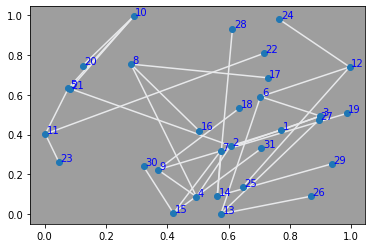

In [ ]:
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

In [ ]:
print(best_solution)
print(fitness_func(best_solution,1))

[0.77228173 0.42324563 0.60691236 0.34358569 0.8990396  0.49335256
 0.49513103 0.08804588 0.07793749 0.63390744 0.70394066 0.59089646
 0.57465199 0.31845716 0.281406   0.75418112 0.36947181 0.2232999
 0.29097944 0.99463074 0.00237657 0.40286356 0.99463931 0.73988322
 0.57481864 0.001425   0.56295145 0.09125287 0.4201761  0.00483621
 0.50342429 0.4200795  0.7275198  0.68554901 0.63537842 0.5326415
 0.98523544 0.50628242 0.12455476 0.74701604 0.08348538 0.63001635
 0.71560573 0.80853195 0.04731808 0.25982533 0.76542859 0.97847356
 0.64735049 0.13829847 0.86728248 0.08979683 0.89440512 0.4731717
 0.61259137 0.93291785 0.93759857 0.25338085 0.32270263 0.23985321
 0.70699814 0.33074127]
0.8459770114942529


#Animacja

Poniżej znajduje się kod przygotujący animację tego, jak na przestrzeni generacji zmieniał się najlepiej dopasowany osobnik. 

Zachęcam do zmiany parametru **interval** w funckji **FuncAnimation**, w celu przyspieszenia/zwolnienia animacji.

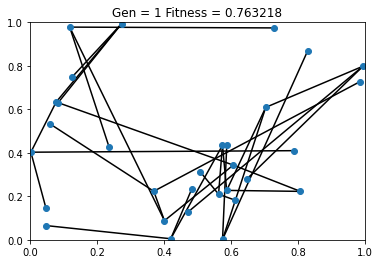

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()
axis = plt.axes(xlim =(0, maxRange),
              ylim =(0, maxRange))
  
points = axis.scatter([], [], zorder=2)
pltLines = []
for v in V:
  line, = axis.plot([], [], color='black', zorder=1)
  pltLines.append(line)

def update(frame):
  axis.set_title(f"Gen = {frame+1} Fitness = {best[frame][1]:.6f}")
  
  hist = best[frame][0]
  G = genG(hist, N)
  points.set_offsets(G)
  for v, l in zip(V, pltLines):
    begin, end = v
    begin, end = begin - 1, end - 1
    X = [G[end][0], G[begin][0]]
    Y = [G[end][1], G[begin][1]]
    l.set_data(X, Y)
  return axis

anim = animation.FuncAnimation(fig, update, frames=len(best),blit=False,repeat=False, interval=100)

HTML(anim.to_html5_video())

#Analiza wyników i wnioski


By przeanalizować działanie algorytmu, przeprowadziliśmy eksperyment, w którym 1000 razy został odpalony algorytm. Uśredniliśmy następnie wyniki i otrzymaliśmy wykres wzrostu precyzji od liczby generacji.

**Notka**: Ta część kodu może się wykonywać bardzo długo, proszę więc nie uruchamiać tego fragmentu bez intencji by ten kod sie dokończył.

In [ ]:
from tqdm import tqdm

records = np.array([0 for _ in range(num_generations)])

def run():
  global best
  ga = init()
  best = []
  ga.run()

for i in tqdm(range(1000)):
  run()
  arr = [record[1] for record in best]
  records = np.add.reduce([records, arr])

records = [record/1000 for record in records]


0.934131578947372


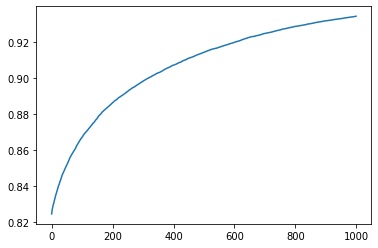

In [ ]:
print(max(records))
plt.plot(range(len(records)), records)
plt.show()

Jak można zauważyć, podstawowy algorytm ma problemy z wyeliminowaniem ostatnich przecięć, przez co średnio po 1000 generacjach tylko ~93% kombinacji krawędzi się nie przecina. Wzrost precyzji jest logarytmiczny, więc widać że największy wzrost dopasowania mamy w pierwszej połowie trwania algorytmu.

Nie jest to najgorczy wynik, często oznacza to że dla graf ma tylko parę przecięć, co oznacza że algorytm nie sprawdza do końca całego dostępnego zakresu.

Patrząc na animację, widać że w końcowych generacjach wartość dopasowania zostaje taka sama, ale zmieniają się same pozycje wierzchołków. Oczywiście wynika to z problemu, gdyż jeżeli istnieje dane ułożenie grafu bez przecięć, to możemy to samo przedstawić na wiele sposobów. Użycie większej ich ilości może pomóc ulepszyć lekko algorytm.


#Eksperymenty

Głównie z powodu biblioteki, z której korzystaliśmy, do funckji mutacji, krzyżowania i selekcji należy wykorzystać wbudowane funkcję biblioteki.

Przy nich zostaną zamieszczone opisy, ale część z nich nie wchodzi w szczegóły jak dokładnie wykonują one operacje.

Warto tutaj nadmienić, że wszystkie każda grupa testów była przeprowadzana na tym samym grafie, jak również testy były powtarzane parę razy, by spróbować zniwelować wpływ losowo dobieranych wartości początkowych w genach na wynik pomiaru.

Sam graf nie jest trywialnym przykładem, jak można zauważyć poniżej, przez co algorytmy szybko się nie zbliżą do dużego dopasowania.

##Funkcja dopasowania

Oczywiście, jest tutaj trochę miejsca do zoptymalizowania liczenia dopasowania, patrząc że może to być znaczące w przypadku dużej liczby wierzchołków i krawędzi.

Pierwszą z nich może być wcześniejsze zatwierdzenie par krawędzi w momencie, gdy mają wspólny wierzchołek. Tutaj jednak nadal trzeba mieć na uwagę, że współrzędne wierzchołków, mogą być zbliżone do siebie w wartości, ale nie równe, temu też rozpatrujemy de facto, czy dany punkt leży w okolicy punktu z drugiej krawędzi, dyktowanym przez jakąś zmienną błędu (w obebnym, innym podejściu jest to $10^{-6}$.

Drugą optymalizacją, zaproponowaną na zajęciach jest przejście z równania kierunkowego na równanie parametryczne prostej:

$$r = r_0 + tv$$

Sprawdzając, czy obliczony parametr t dla nowo obliczonego przecięcia jest w przedziale **(0,1)**

##Testy funkcji mutacji

###Random

62
0.832183908045977
1000


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


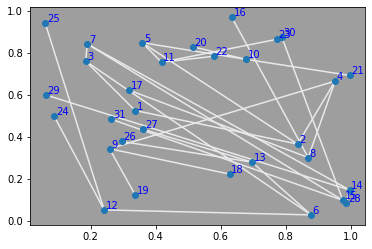

[0.33674298 0.52537127 0.83685814 0.36525162 0.18412768 0.76149968
 0.95244981 0.66576638 0.35858014 0.84942184 0.87836083 0.02681431
 0.18961934 0.84303614 0.86964127 0.30101085 0.25794412 0.34281712
 0.67784246 0.76985196 0.41806109 0.75597417 0.24126468 0.05076377
 0.69679079 0.27888657 0.99675277 0.14593486 0.97608634 0.09657171
 0.63424257 0.97088674 0.3187586  0.62242985 0.6279566  0.22166385
 0.33664275 0.12344225 0.51339893 0.82998858 0.99721856 0.69318696
 0.57949219 0.78471141 0.77212781 0.86525455 0.08759501 0.49792156
 0.06010507 0.94149909 0.29509446 0.37779892 0.36222324 0.43533783
 0.98652895 0.08416407 0.06223451 0.59957025 0.78863289 0.87505153
 0.26366781 0.48352562]
0.832183908045977


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    # stop_criteria='saturate_30',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###Swap

62
0.8781609195402299
49


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


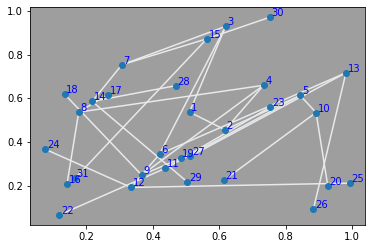

[0.5104812  0.53722282 0.61731222 0.45571108 0.61910175 0.93022123
 0.73322472 0.65974939 0.84351627 0.61312121 0.42012971 0.34416711
 0.30657328 0.75391964 0.17669505 0.53675143 0.36651993 0.24830677
 0.89136983 0.53505377 0.43722938 0.27901674 0.33442376 0.19143397
 0.98146673 0.71742543 0.21740205 0.58589487 0.56252183 0.873033
 0.14154761 0.20848824 0.26416562 0.61731222 0.13394521 0.61910175
 0.48385061 0.32466799 0.9265673  0.1995503  0.61312121 0.2234055
 0.11882633 0.06548468 0.75391964 0.56031824 0.07609729 0.36651993
 0.99255222 0.21119794 0.88320959 0.0913367  0.51295068 0.33442376
 0.46870693 0.65799905 0.50333596 0.21740205 0.75226048 0.97192297
 0.16532793 0.23299429]
0.8781609195402299


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="swap",
    stop_criteria='saturate_20',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###Wnioski

Funkcje random i swap poddawane testom dają bardzo zbliżone wyniki. Średnio jednak funkcja swap dawała nieco lepsze wyniki. Stwierdziliśmy jednak że będziemy używać mutacji losowych, ponieważ różnica jest znikoma a czas wykonania algorytmu z użyciem funkcji swap był średnio dłuższy.

Warto tutaj też zanotować, że są jeszcze inne funkcje notacji w bibliotece, lecz nie zadziałały nam one z naszymi danymi, wyrzucając błąd. Dokumentacja niestety nie była pomocna w naprawieniu ich, przez to tylko dwie dostępne funkcje zostały tu przedstawione.

##Prawdopodobieństwo mutacji.

Działając na funkcji mutacji random, wykonaliśmy część testów w których zmieniane było prawdopodobieństwo zaistnienia mutacji.

###0.5%

62
0.735632183908046
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


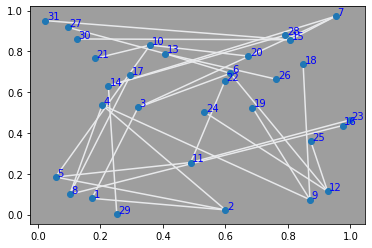

[0.17325673 0.0791428  0.60011164 0.02264753 0.3209228  0.5252896
 0.20596001 0.53712738 0.05671101 0.18366504 0.61599615 0.69223263
 0.95210062 0.97230396 0.10220338 0.0988832  0.8702766  0.07303087
 0.35906287 0.83078046 0.4889559  0.25484165 0.92679901 0.1136922
 0.40630216 0.78925179 0.22556071 0.63080189 0.8075173  0.85701997
 0.9751819  0.43639325 0.29613242 0.68294661 0.84851842 0.73693713
 0.68639285 0.52465047 0.67285484 0.77696226 0.18283243 0.76523373
 0.59842826 0.65504039 0.99734144 0.46328341 0.53293638 0.50281595
 0.8731144  0.35839507 0.76262922 0.66369623 0.09590864 0.91798727
 0.79145268 0.87920839 0.25249467 0.00287661 0.12415716 0.86085562
 0.0239072  0.95082362]
0.735632183908046


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 0.5

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### 1%

62


/usr/local/lib/python3.8/dist-packages/pygad/pygad.py:503: UserWarning: The percentage of genes to mutate (mutation_percent_genes=1) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


0.9747126436781609
133


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


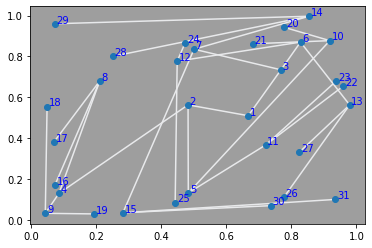

[0.66770884 0.51009597 0.48278196 0.56299242 0.7682323  0.73465611
 0.08640775 0.13029266 0.48349999 0.13217665 0.82812221 0.87014112
 0.50120531 0.83538358 0.21160454 0.67997343 0.04432626 0.03233028
 0.91830123 0.87730549 0.72116738 0.36687463 0.44942563 0.77664979
 0.97908919 0.56286483 0.8541376  0.99669705 0.28269927 0.03512752
 0.07419149 0.17164754 0.07096406 0.38162309 0.04980974 0.5550545
 0.19510793 0.02947919 0.77817763 0.94247228 0.68196271 0.86190053
 0.96000583 0.65559115 0.93757115 0.67916089 0.47383054 0.8661556
 0.44317288 0.08513332 0.77678795 0.11030752 0.82415074 0.33086696
 0.2518546  0.80034519 0.07348822 0.95990703 0.7378905  0.0700111
 0.9349906  0.10033252]
0.9747126436781609


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 1

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_20',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###5%

62
0.7885057471264367
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


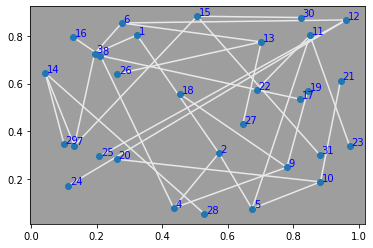

[0.32338864 0.80390954 0.57338345 0.30747952 0.19412285 0.72544765
 0.43538053 0.07668052 0.67456628 0.07404289 0.2768969  0.85469329
 0.13237335 0.33853014 0.21185308 0.71732037 0.7806297  0.24818754
 0.88325482 0.18672811 0.85132032 0.80248322 0.96135101 0.86748234
 0.70258198 0.77531515 0.04367887 0.64420074 0.50680524 0.88300484
 0.12856418 0.79536677 0.82037915 0.53469463 0.45508191 0.55552408
 0.84453339 0.56908417 0.26273427 0.28183377 0.94446853 0.61175241
 0.68831377 0.57336128 0.97233635 0.33798464 0.11348663 0.17112021
 0.20827863 0.29387749 0.26305748 0.64037531 0.64645019 0.42999248
 0.52936558 0.05205545 0.10090919 0.34514209 0.82296628 0.87767114
 0.88042159 0.3015594 ]
0.7885057471264367


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 5

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###7%

62
0.767816091954023
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


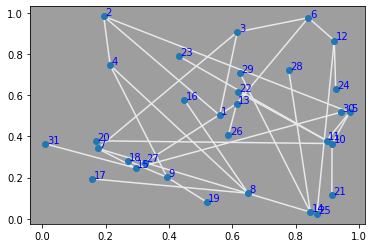

[0.55997054 0.5021715  0.1940347  0.98262428 0.61555058 0.90617857
 0.21457522 0.74470237 0.9702386  0.51683506 0.83989932 0.97528974
 0.17512447 0.3413891  0.64983665 0.12406486 0.39410829 0.20163859
 0.91467458 0.36505505 0.89730133 0.37955433 0.92163752 0.86486137
 0.61340627 0.55822024 0.84631487 0.03258739 0.29492964 0.24647059
 0.44868082 0.57654891 0.15652219 0.19397586 0.26944426 0.28166893
 0.51868306 0.08191239 0.16969127 0.37850517 0.91398007 0.11675909
 0.61754258 0.61546267 0.43098437 0.78947246 0.92626883 0.62787595
 0.866891   0.02383362 0.58764118 0.40566415 0.32287944 0.27242767
 0.77796207 0.72151928 0.6234748  0.7081501  0.94280269 0.51710544
 0.00973074 0.36376774]
0.767816091954023


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 7

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### 25%

62
0.7494252873563219
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


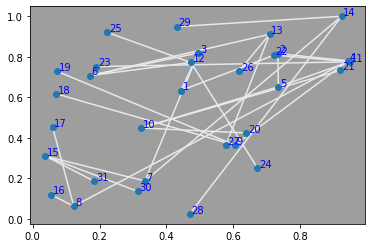

[0.44374946 0.63355515 0.73478144 0.81524985 0.49622595 0.81888283
 0.94518854 0.78013773 0.73543694 0.6520114  0.17083395 0.70681028
 0.33589694 0.18752866 0.1228422  0.06296681 0.60566078 0.36423064
 0.3245117  0.44883243 0.94926916 0.77509679 0.47370794 0.77184866
 0.70949237 0.91072238 0.92543106 0.99971464 0.03760067 0.31028321
 0.05424981 0.12072614 0.05957941 0.45211653 0.07093057 0.61686628
 0.07397678 0.72753068 0.63944511 0.42429275 0.92142064 0.73242249
 0.72219489 0.8086029  0.19050364 0.75136801 0.67286724 0.25253804
 0.2235204  0.92001255 0.61854171 0.73061388 0.5784805  0.36324641
 0.47049687 0.02507221 0.43209973 0.94851739 0.31414607 0.13644362
 0.18416759 0.18652015]
0.7494252873563219


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 25

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### Wnioski

Wniosek: dalsze zwiększanie prawdopobieństwa nie ma pozytywnego wpływu na działanie algorytmu. Co ma sens, patrząc na to, że nie chcemy cały czas zmieniać naszych genów w sposób losowy, jak w bogo sorcie, a chcemy się zbliżać do rozwiązania.

Wartości dopasowania są albo zbliżone do algorytmu kontrolnego albo gorsze.
Dla tego problemu mniejsze prawdopodobieństwo mutacji okazywało się najlepsze, najlepiej z przedziału (0,1], więc za najlepszą wartość mutation_percent_genes wybraliśmy **1%**.

##Testy funkcji krzyżowania.

Przeprowadziliśmy eksperymenty dla różnych funkcji krzyżowania, które są dostępne w bibliotece.

###Single Point

62
0.8505747126436781
230


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


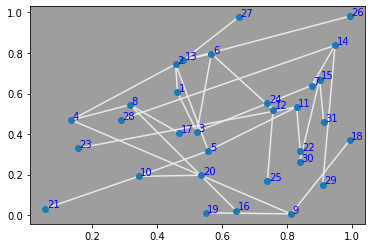

[0.46297215 0.60677304 0.45759067 0.74514755 0.52305232 0.41181949
 0.13647784 0.46955362 0.55780676 0.31724986 0.56778398 0.79664203
 0.8762257  0.63965821 0.31689367 0.54441887 0.81251021 0.00633388
 0.34360663 0.1916723  0.82985273 0.53392183 0.757413   0.52088918
 0.48157675 0.7651752  0.94808985 0.83776843 0.90077168 0.66864969
 0.64346228 0.02266197 0.46836365 0.40523193 0.99306398 0.36880374
 0.54965462 0.01191444 0.53699852 0.19724636 0.05642663 0.03267012
 0.8411867  0.31641052 0.15635076 0.33015225 0.74003708 0.55458187
 0.74006542 0.1696468  0.99293432 0.98135373 0.6517482  0.97786347
 0.28801696 0.47036517 0.91003565 0.15089597 0.83878257 0.26093643
 0.9129905  0.45937411]
0.8505747126436781


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N
print(num_genes)

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###Two Points

62
0.7839080459770115
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


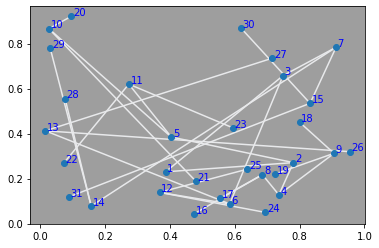

[0.38677889 0.23014213 0.78124122 0.27101446 0.74891836 0.65761368
 0.73612774 0.12796051 0.40424332 0.38472647 0.58446963 0.08732673
 0.91265035 0.78381334 0.68531495 0.21736921 0.90642602 0.31227218
 0.02640262 0.8665112  0.27314733 0.61986959 0.36813643 0.13865508
 0.01538857 0.41241464 0.15699307 0.07794643 0.83255434 0.53474051
 0.47405865 0.04291843 0.55392925 0.1119517  0.80041566 0.45015857
 0.72397061 0.22026021 0.09612061 0.92175155 0.47961589 0.18891913
 0.07290316 0.26953867 0.59452692 0.42543658 0.69405183 0.04971808
 0.63922845 0.24210995 0.9546068  0.31975175 0.71583241 0.73520227
 0.07645654 0.55546462 0.03048231 0.77976262 0.61881097 0.86977416
 0.08726811 0.11797007]
0.7839080459770115


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='two_points',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###Uniform

62
0.7632183908045977
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


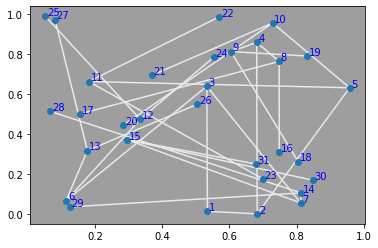

[0.53468241 0.0156194  0.68282292 0.0024792  0.53284646 0.63844166
 0.68140623 0.85664222 0.95833694 0.63099648 0.11382552 0.06862851
 0.81244707 0.05713035 0.74844456 0.76204205 0.60468669 0.81105775
 0.7287114  0.95351644 0.18136748 0.6619886  0.33453065 0.47372947
 0.17709898 0.31834191 0.81368799 0.10701743 0.29486766 0.3723386
 0.7486255  0.31225635 0.15509691 0.50089658 0.80519594 0.26292228
 0.83248477 0.78911679 0.2838504  0.44440577 0.36843667 0.69244365
 0.57021261 0.98444031 0.69958687 0.17764412 0.55308364 0.782868
 0.0517277  0.98726329 0.50424209 0.54844129 0.08059532 0.97082056
 0.06669242 0.5132077  0.12483355 0.037509   0.84813261 0.17069592
 0.67793908 0.25131557]
0.7632183908045977


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N
print(num_genes)

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='uniform',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###Scattered

62
0.7724137931034483
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


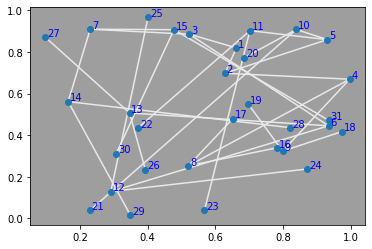

[0.66196106 0.81940672 0.62844377 0.69749691 0.52361283 0.88504435
 0.99627705 0.66896015 0.93005515 0.85933405 0.93394226 0.44490002
 0.23073811 0.90921744 0.52050629 0.25276813 0.79844988 0.32332356
 0.83893217 0.90789806 0.70193041 0.90224128 0.29145751 0.12912
 0.34681104 0.50657761 0.16552095 0.56135469 0.47798902 0.90699115
 0.78209343 0.33927272 0.65160207 0.47957215 0.97367049 0.41726814
 0.69742524 0.54854486 0.68539432 0.77268148 0.22984449 0.03831621
 0.37238055 0.4356576  0.56780459 0.0390012  0.87080804 0.23724994
 0.40136654 0.96673204 0.39336828 0.23421487 0.09811067 0.87078183
 0.82128451 0.43583197 0.34894446 0.01661015 0.30736491 0.31125824
 0.93472681 0.47092493]
0.7724137931034483


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N
print(num_genes)

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='scattered',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### Wnioski

Ze wszystkich metod, krzyżowanie jednopunktowe daje najlepsze wyniki spośród podanych. Może to być spowodowane elementem losowym w metodach krzyżowania oraz strukturze genu. Gen jest podzielony na pary liczb, które są punktami wierzchołków, przez co krzyżowanie ich z położeniem innego punktu nie ma za bardzo sensu.

##Prawdopodobieństwo krzyżowania

Dla różnych wartości prawdopodobieństwa krzyżowania sprawdziliśmy jakie wyniki daje algorytm.

### 100%

62
0.7816091954022989
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


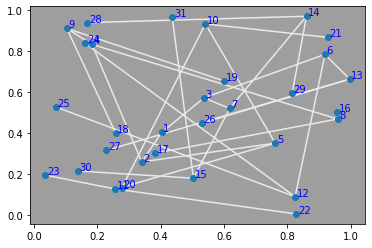

[0.4034782  0.40334048 0.34059814 0.25901906 0.53729726 0.57191252
 0.18377525 0.83269529 0.76181871 0.35046298 0.91870148 0.78416211
 0.61789831 0.52005663 0.9589966  0.46836151 0.10404542 0.91109437
 0.5414375  0.93319188 0.25759237 0.12632137 0.82444184 0.08899093
 0.99657562 0.66343289 0.86040131 0.97062124 0.50357275 0.17909865
 0.95782487 0.50099566 0.38227538 0.30131438 0.25842674 0.39808752
 0.60001083 0.65450245 0.2770788  0.13049537 0.92721419 0.86736382
 0.82808364 0.0047672  0.03617552 0.19431394 0.16213029 0.83839467
 0.06903525 0.52778929 0.52997653 0.4476616  0.22865548 0.31493469
 0.16930365 0.93930561 0.81509049 0.59332579 0.13913386 0.21467065
 0.43663057 0.96690737]
0.7816091954022989


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10
crossover_probability = 1

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    crossover_probability=crossover_probability,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### 75%

62
0.7839080459770115
103


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


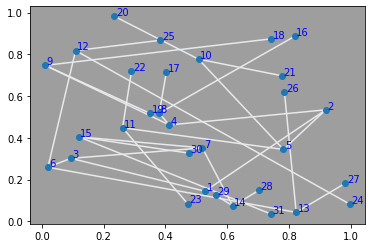

[0.52796981 0.1447764  0.91955947 0.53449836 0.09340546 0.3020359
 0.41264427 0.46193612 0.78240666 0.34470338 0.0191982  0.25946129
 0.51979569 0.35194641 0.37977398 0.51759796 0.01066117 0.74720627
 0.5071934  0.77708464 0.2609442  0.44845919 0.10895522 0.81822657
 0.82382048 0.04335305 0.61828856 0.07375779 0.1185257  0.40555276
 0.81921799 0.88685002 0.40325925 0.7168447  0.74317038 0.8744778
 0.35008492 0.51765696 0.23405043 0.98264727 0.77755672 0.69755785
 0.28991166 0.71803269 0.4719846  0.0848041  0.99706138 0.08315702
 0.38335247 0.86748005 0.78577685 0.61787485 0.98294745 0.18270197
 0.70370738 0.14961186 0.56437076 0.12489964 0.47653662 0.32666993
 0.74130193 0.03587221]
0.7839080459770115


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10
crossover_probability = 0.75

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    crossover_probability=crossover_probability,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### 50%

62
0.7425287356321839
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


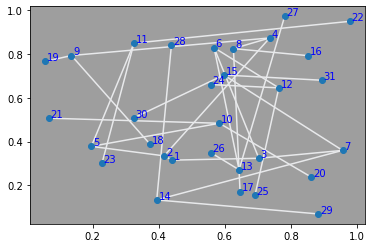

[0.44085943 0.3146996  0.41627264 0.33424949 0.70339453 0.3232666
 0.73608718 0.87386297 0.19584084 0.37772058 0.5676087  0.82954707
 0.95689388 0.35931842 0.62621769 0.82519796 0.13540449 0.79356803
 0.58378504 0.4834359  0.32500123 0.85003824 0.7638411  0.64547996
 0.64334444 0.27064642 0.39390001 0.13269699 0.59749568 0.70434102
 0.85207535 0.79307329 0.64634267 0.17054254 0.37336835 0.38838573
 0.05629644 0.76624994 0.8621896  0.23710311 0.06703887 0.50673689
 0.97841902 0.94994148 0.22826568 0.30155299 0.55797207 0.66060565
 0.6914818  0.15308957 0.5580677  0.34876778 0.78160501 0.97331545
 0.43849095 0.84246708 0.88281614 0.0685739  0.32406977 0.50787201
 0.89456927 0.68043461]
0.7425287356321839


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10
crossover_probability = 0.5

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N
print(num_genes)

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    crossover_probability=crossover_probability,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### 25%

62
0.774712643678161
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


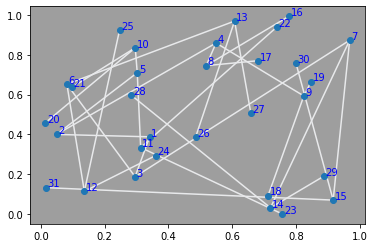

[3.40874601e-01 3.87548874e-01 4.92757470e-02 3.99583329e-01
 2.95461084e-01 1.87269477e-01 5.48987587e-01 8.58778163e-01
 3.02117142e-01 7.09543916e-01 8.16425781e-02 6.52120295e-01
 9.67495588e-01 8.72538626e-01 5.18195354e-01 7.45045945e-01
 8.23977977e-01 5.92840614e-01 2.95872968e-01 8.34948413e-01
 3.12832949e-01 3.33784489e-01 1.36415805e-01 1.13830819e-01
 6.07025102e-01 9.69015449e-01 7.19497734e-01 3.10264118e-02
 9.15862768e-01 6.97535602e-02 7.77119396e-01 9.93166985e-01
 6.80458098e-01 7.69884072e-01 7.11900259e-01 9.24459251e-02
 8.47076432e-01 6.65070513e-01 1.40830571e-02 4.58006523e-01
 9.65793595e-02 6.35336811e-01 7.38657170e-01 9.38164761e-01
 7.56136075e-01 3.66897254e-04 3.59424884e-01 2.93197205e-01
 2.46747775e-01 9.23483739e-01 4.85122441e-01 3.87456689e-01
 6.57692306e-01 5.08510997e-01 2.83270801e-01 5.96936546e-01
 8.86894318e-01 1.90093036e-01 7.99187690e-01 7.57772562e-01
 1.57852336e-02 1.32323215e-01]
0.774712643678161


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10
crossover_probability = 0.25

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N
print(num_genes)

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    crossover_probability=crossover_probability,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### 0%

62
0.8183908045977012
285


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


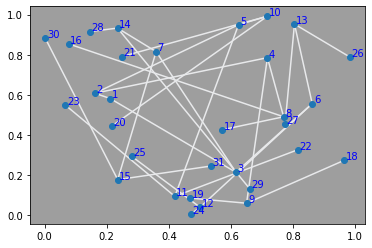

[0.21101315 0.58184055 0.16181602 0.60822322 0.61633096 0.21468606
 0.71789205 0.78522616 0.62491022 0.94951066 0.86218797 0.55646217
 0.35912316 0.81531603 0.77008304 0.49098228 0.65061941 0.06062438
 0.71748809 0.99146543 0.41939169 0.09495299 0.50058968 0.04067592
 0.80504365 0.95243688 0.23486769 0.93248854 0.23543017 0.17790331
 0.0774603  0.85373389 0.57289681 0.42651936 0.96423174 0.27352588
 0.46878119 0.08618926 0.21581367 0.44413126 0.24924411 0.79076983
 0.81539843 0.32661402 0.06688989 0.54886119 0.4716184  0.00740999
 0.28017295 0.29434141 0.98287518 0.78907473 0.77482065 0.45611326
 0.14581555 0.91522901 0.66049416 0.13335103 0.00196936 0.88172702
 0.53525314 0.2456305 ]
0.8183908045977012


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10
crossover_probability = 0

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    crossover_probability=crossover_probability,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### Wnioski

Wychodzi na to, że małe prawdopodobieństwo krzyżowania dało nam lepsze średnie wyniki.

##Testy funkcji selekcji

Następnie przetestowaliśmy wbudowane funkcje selekcji.

###steady-state selection

62
0.7724137931034483
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


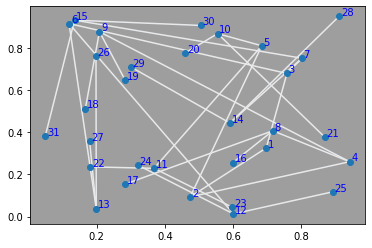

[0.6970092  0.32512705 0.47406065 0.09316757 0.75759113 0.67809397
 0.9414201  0.25992613 0.68385486 0.80941198 0.11910449 0.91451321
 0.80164954 0.75034082 0.71616052 0.40654278 0.20821724 0.87595083
 0.5545395  0.86687885 0.36829492 0.22858253 0.6009562  0.01254149
 0.19886045 0.0373625  0.59067373 0.44303149 0.13515829 0.93071489
 0.59947883 0.25612716 0.28407699 0.15412837 0.16685444 0.51201985
 0.28307428 0.64800651 0.45994416 0.77602114 0.86817097 0.37710377
 0.18071613 0.23549609 0.59787409 0.04381157 0.3197504  0.24461621
 0.89123282 0.11707417 0.19807315 0.7597072  0.17920202 0.35926539
 0.91060944 0.94923251 0.29953322 0.70944752 0.50515356 0.90566365
 0.04948194 0.38222414]
0.7724137931034483


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N
print(num_genes)

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
    parent_selection_type='sss',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###roulette wheel selection

62
0.8574712643678161
212


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


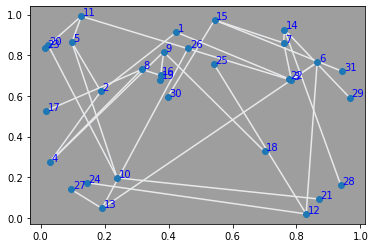

[0.42467814 0.91352796 0.18806907 0.62264244 0.78427127 0.67905394
 0.02949418 0.27498905 0.0975296  0.86337763 0.86478587 0.76492003
 0.75997217 0.86054456 0.31648914 0.73019685 0.38463588 0.81707812
 0.23883043 0.19657002 0.12694609 0.9921546  0.83044572 0.01886382
 0.19186079 0.0459916  0.76245376 0.92667371 0.54379451 0.97338208
 0.37557674 0.70074843 0.01615575 0.52583628 0.70029094 0.32640099
 0.37362892 0.6805441  0.02283743 0.8514569  0.86934922 0.09246016
 0.77703124 0.68111094 0.01437513 0.83597002 0.14353076 0.17264796
 0.54233279 0.75588526 0.46197284 0.83725053 0.09590599 0.13918491
 0.93869334 0.16077694 0.96644128 0.59134714 0.39698855 0.59431083
 0.94400719 0.72040697]
0.8574712643678161


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
    parent_selection_type='rws',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###stochastic universal selection

62
0.8597701149425288
200


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


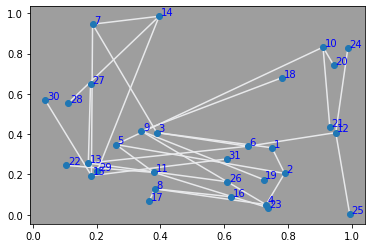

[0.74992316 0.33260381 0.7897109  0.20556972 0.38833216 0.40784075
 0.73166673 0.05008045 0.26012668 0.34856341 0.67372368 0.33983797
 0.18698653 0.94561417 0.38214506 0.12884789 0.3398905  0.41536199
 0.91037066 0.83171807 0.37985964 0.20986864 0.95027025 0.40756866
 0.17365223 0.25649659 0.39603944 0.98508237 0.18337591 0.19401161
 0.62080377 0.08937949 0.36464359 0.06669631 0.7809694  0.67962431
 0.72369775 0.17471902 0.94418346 0.74126476 0.93168187 0.43509878
 0.10450906 0.24504428 0.73773957 0.03493214 0.98822591 0.82565399
 0.9939422  0.00416523 0.61012813 0.163852   0.18055446 0.64737225
 0.11078196 0.55424735 0.20192324 0.21675434 0.03856706 0.5683257
 0.6082409  0.27681576]
0.8597701149425288


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
    parent_selection_type='sus',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###rank selection

62
0.8137931034482758
378


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


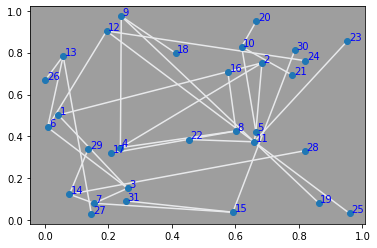

[4.21472407e-02 5.01813537e-01 6.83426961e-01 7.50735395e-01
 2.60304989e-01 1.52338709e-01 2.37549295e-01 3.46118133e-01
 6.64577656e-01 4.22569383e-01 8.11785053e-03 4.43115833e-01
 1.54578264e-01 8.05885558e-02 6.01739717e-01 4.25922859e-01
 2.40250637e-01 9.73690442e-01 6.19723789e-01 8.28014462e-01
 6.59017782e-01 3.74097197e-01 1.94114601e-01 9.03410030e-01
 5.71608705e-02 7.83996919e-01 7.69377334e-02 1.23578891e-01
 5.91846483e-01 3.78797550e-02 5.76198587e-01 7.06041836e-01
 2.08470296e-01 3.20197074e-01 4.11617102e-01 7.97567898e-01
 8.62042561e-01 8.30499523e-02 6.65865286e-01 9.50734018e-01
 7.79212136e-01 6.92767509e-01 4.53965933e-01 3.84912857e-01
 9.52862506e-01 8.55412488e-01 8.19927706e-01 7.61493243e-01
 9.59999536e-01 3.20289272e-02 8.07461387e-04 6.68657046e-01
 1.46020223e-01 2.98290958e-02 8.17754888e-01 3.31226904e-01
 1.35915194e-01 3.39181425e-01 7.86942460e-01 8.10751276e-01
 2.54311041e-01 9.23304327e-02]
0.8137931034482758


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
    parent_selection_type='rank',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###random selection

62
0.7885057471264367
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


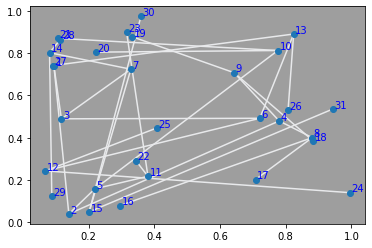

[0.0943615  0.74075138 0.1399175  0.03893467 0.11719995 0.48951364
 0.78011618 0.47951141 0.21908423 0.15775366 0.72104865 0.49202174
 0.32865964 0.72452993 0.88055752 0.4002775  0.64289618 0.70800093
 0.77588774 0.81312914 0.38061781 0.21715475 0.06822314 0.24293961
 0.82411083 0.89121342 0.08117329 0.80279786 0.20170738 0.04845026
 0.2953157  0.07822963 0.70818273 0.20183951 0.88389873 0.38421773
 0.3331217  0.87816565 0.22133671 0.80541387 0.10538268 0.87104281
 0.34395313 0.29129245 0.31564689 0.90000135 0.99460496 0.13971195
 0.40785869 0.4462691  0.80714012 0.53150936 0.09101417 0.74189651
 0.11389428 0.86485184 0.08803102 0.12389715 0.35947052 0.97550153
 0.94423943 0.53652428]
0.7885057471264367


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
    parent_selection_type='random',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

###tournament selection

62
0.7540229885057471
100


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


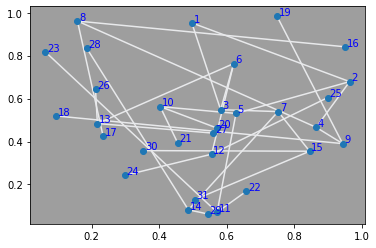

[0.4964337  0.95261495 0.964283   0.67894873 0.58195962 0.54814533
 0.86505321 0.46615169 0.62743734 0.53084748 0.62061438 0.76289422
 0.75228511 0.53943802 0.1576205  0.9610109  0.94360708 0.39032971
 0.40266327 0.56258797 0.57136928 0.07077965 0.55512504 0.3409966
 0.21670101 0.48388475 0.48641911 0.08192225 0.84569607 0.35484866
 0.95114963 0.84107911 0.23348017 0.4260919  0.09470044 0.51919783
 0.74895303 0.98337314 0.57091858 0.46285194 0.45420318 0.39503574
 0.65742483 0.16766629 0.06230379 0.81771542 0.29805333 0.24241574
 0.89921323 0.60443391 0.21110219 0.64287358 0.56023405 0.43912215
 0.18489235 0.8348729  0.54348368 0.06295227 0.3527981  0.35772997
 0.50574644 0.12983398]
0.7540229885057471


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 10

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
    parent_selection_type='tournament',
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

### Wnioski

Stochastic Universal Selection daje najlepsze wyniki spośród wszystkich.

#Podsumowanie

##Najlepszy wybór

Wybraliśmy wszystkich zwycięzców testów, by sprawdzić jak razem bedą się zachowywać.

62
0.9770114942528736
808


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


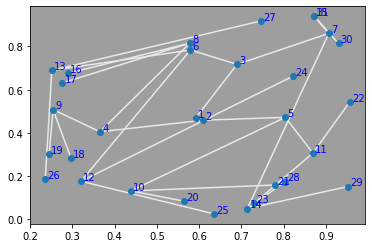

[0.59173871 0.46901149 0.60959651 0.4588148  0.68964369 0.71697698
 0.36526818 0.40541949 0.80392126 0.47217658 0.57940905 0.78334235
 0.90683972 0.86013654 0.57805637 0.81506846 0.25418732 0.50819303
 0.43808501 0.13178538 0.86910169 0.30689629 0.32040369 0.17650336
 0.2512289  0.68915918 0.71398544 0.05040768 0.87229426 0.93943433
 0.28946785 0.67592823 0.27649799 0.63120866 0.29655868 0.28443672
 0.24495908 0.30165057 0.56471963 0.08454231 0.77923523 0.15924991
 0.95611169 0.54265039 0.73010212 0.07440882 0.82175956 0.66212964
 0.63578915 0.02558704 0.23587429 0.18740214 0.74673846 0.91796044
 0.80381694 0.17538113 0.95145705 0.15185262 0.92976517 0.8138703
 0.87281195 0.93862147]
0.9770114942528736


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 1
crossover_probability = 0.05

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N

best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
    parent_selection_type='sus',
    crossover_probability=crossover_probability,
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

Dane parametry dają rezultat w postaci procentu kombinacji krawędzi nieprzecinających się około 97.7% po 808 generacjach dla dużego drzewa binarnego z 31 wierchołkami. Dla porównania algorytm kontrolny miał ten sam procent na wartości 84.59%.

Widać też w takim razie, że udało się zoptymalizować algorytm.

Następnie wykonaliśmy wykres zmiany wartości dopasowania dla jednego przebiegu algorytmu.

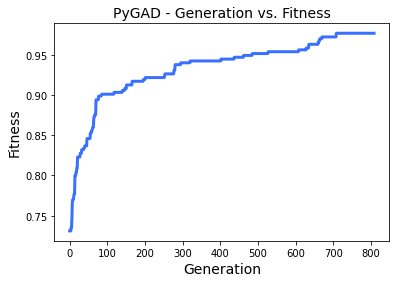

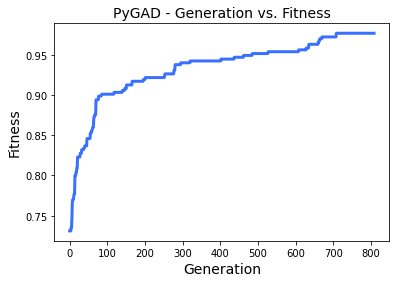

In [ ]:
ga.plot_fitness()

Jak można zauważyć, dopasowanie szybciej wzrosło do wartości około 90%, gdzie do tej wartości poprzednio algorytm dochodził w około 500 generacji.

Poniżej jeszcz znajduje się animacja dla zoptymalizowanego algorytmu.

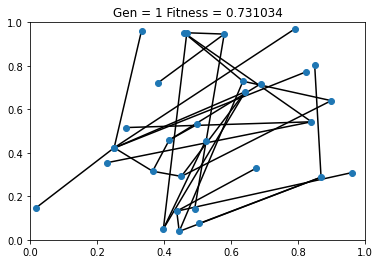

In [ ]:
fig = plt.figure()
axis = plt.axes(xlim =(0, maxRange),
              ylim =(0, maxRange))
  
points = axis.scatter([], [], zorder=2)
pltLines = []
for v in V:
  line, = axis.plot([], [], color='black', zorder=1)
  pltLines.append(line)

def update(frame):
  axis.set_title(f"Gen = {frame+1} Fitness = {best[frame][1]:.6f}")
  
  hist = best[frame][0]
  G = genG(hist, N)
  points.set_offsets(G)
  for v, l in zip(V, pltLines):
    begin, end = v
    begin, end = begin - 1, end - 1
    X = [G[end][0], G[begin][0]]
    Y = [G[end][1], G[begin][1]]
    l.set_data(X, Y)
  return axis

anim = animation.FuncAnimation(fig, update, frames=len(best),blit=False,repeat=False, interval=100)

HTML(anim.to_html5_video())

##Mniejszy Graf z mutacjami


In [ ]:
# poprawione, działa
N = 0
V = []

with open('graf_small.txt', 'r') as f:
  lines = f.readlines()
  N = int(lines[0])
  input = lines[1].strip().split()
  for i in range(0, len(input), 2):
    V.append((int(input[i]), int(input[i+1])))

30
1.0
286


<ipython-input-61-829a01a0db89>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axs = plt.axes()


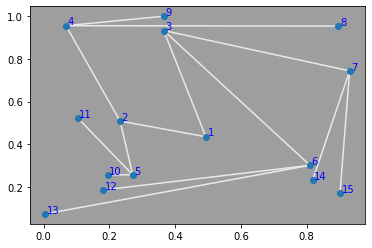

[0.49319996 0.43566129 0.23270604 0.5089242  0.36526786 0.93185751
 0.06793987 0.9543816  0.27101111 0.25786363 0.81007741 0.30218023
 0.93072248 0.74332599 0.89624962 0.95266315 0.36523206 0.99859602
 0.19489108 0.25789467 0.1035646  0.52371381 0.18121596 0.18703699
 0.00522637 0.07501199 0.8180238  0.23180499 0.9012927  0.17116459]
1.0


In [ ]:
num_generations = 1000 # Number of generations.
num_parents_mating = 7 # Number of solutions to be selected as parents in the mating pool.
mutation_percent_genes = 1
crossover_probability = 0.05

init_range_low = 0
init_range_high= maxRange

sol_per_pop = 50 # Number of solutions in the population.
num_genes = 2 * N
best = []
last_fitness_b = 0
def callback_generation(ga_instance):
    global last_fitness_b, best
    last_fitness_b = ga_instance.best_solution()[1]
    best.append(ga_instance.best_solution())

def init():
  return pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating, 
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop, 
    num_genes=num_genes,
    mutation_percent_genes=mutation_percent_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    on_generation=callback_generation,
    mutation_type="random",
    stop_criteria='saturate_100',
    crossover_type='single_point',
    parent_selection_type='sus',
    crossover_probability=crossover_probability,
)
  
# Run the genetic algorithm.
ga = init()
best = []
ga.run()
# This will find the center and radius of the largest circle inscribed in the square.
best_solution, best_fitness, best_solution_idx = ga.best_solution()

G = genG(best_solution, N)

print(f' Best fitness {best_fitness}')
drawGraph(G,V)

Dla mniejszego drzewa z 15 wierchołkami zero przecięć występuje już przy 286 generacjach z użyciem mutacji.

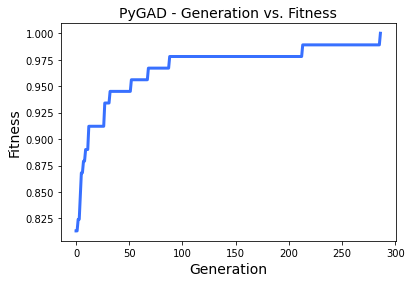

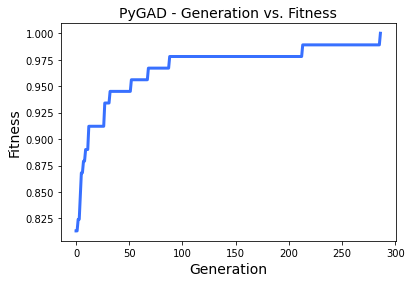

In [ ]:
ga.plot_fitness()

Tak samo jak to było powiedziane wcześniej, użyskujemy duże dopasowanie w około 100 generacjach.

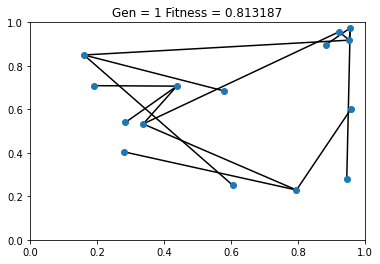

In [ ]:
fig = plt.figure()
axis = plt.axes(xlim =(0, maxRange),
              ylim =(0, maxRange))
  
points = axis.scatter([], [], zorder=2)
pltLines = []
for v in V:
  line, = axis.plot([], [], color='black', zorder=1)
  pltLines.append(line)

def update(frame):
  axis.set_title(f"Gen = {frame+1} Fitness = {best[frame][1]:.6f}")
  
  hist = best[frame][0]
  G = genG(hist, N)
  points.set_offsets(G)
  for v, l in zip(V, pltLines):
    begin, end = v
    begin, end = begin - 1, end - 1
    X = [G[end][0], G[begin][0]]
    Y = [G[end][1], G[begin][1]]
    l.set_data(X, Y)
  return axis

anim = animation.FuncAnimation(fig, update, frames=len(best),blit=False,repeat=False, interval=100)

HTML(anim.to_html5_video())